# Python Optimization

In this section we will discuss python optimization.  The key fact about python optimization is several-fold.
1. Is your code correct?
2. Do you need to optimize?
3. Do you really need to optimize?
4. Optimize is not parallelization -- usually do this last.
5. Optimization involves tradeoffs.  Be careful what you wish for.

There are a few steps to optimization:
1. profile
2. profile again.
3. check the hotspots.
4. payoff in optimization: modify your use case, use better algorithms, use builtin functions, use numba, pre-compiled code



## Profiling

The first and most important aspect of optimization is to figure out what is the slow part.  For this you need to profile your code.  Fortunately python offers some excellent profilers and jupyter has step this part up even further.  For this, we will use the line decorated %prun.  

<IPython.core.display.Javascript object>


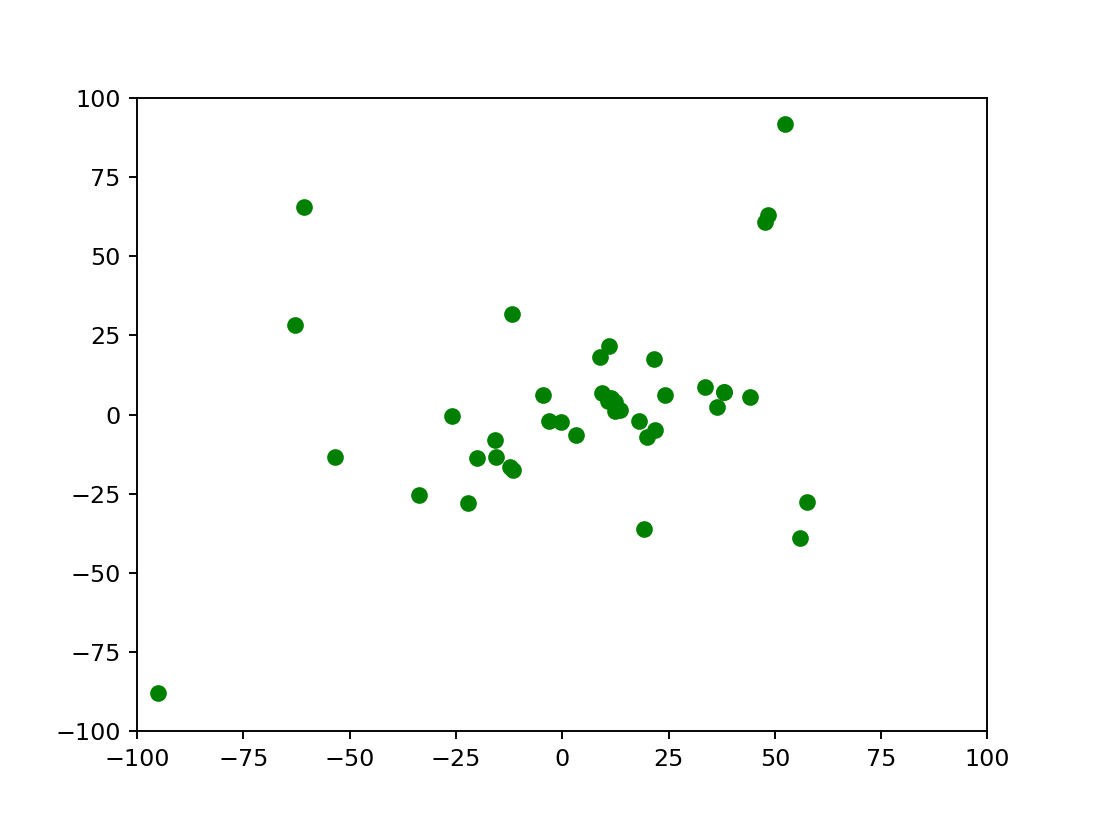

In [8]:
import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt
N_massive = 50
N_bodies = N_massive
M = np.ones(N_bodies)

def Nbody_derivatives(pos,vel) :
    dpdt = vel
    dvdt = np.zeros(vel.shape)
    for i in range(N_bodies) :
        for j in range(N_bodies) :
            if i == j : 
                continue
            r = np.linalg.norm( pos[j]-pos[i])
            mass = M[j]
            rhat =(pos[j] - pos[i])/r
            dvdt[i] += mass/(r*r)*rhat
        
    return dpdt, dvdt

def initial_conditions() : 
    pos = np.random.random([N_bodies,3])
    vel = np.random.random([N_bodies,3])

    return pos, vel

def run_Nbody_rk2(tend,tframe,dt,derivatives=Nbody_derivatives) :
    p,v = initial_conditions()
    t = 0
    tnext = tframe
    positions = []
    while t<tend :
        while t < tnext :
            delta_t = min(tnext-t,dt)
            dpdt, dvdt = derivatives(p,v) 
            phalf, vhalf = p+dpdt*0.5*delta_t, v+dvdt*0.5*delta_t
            dpdt, dvdt = derivatives(phalf, vhalf)
            p, v = p + dpdt*delta_t, v + dvdt*delta_t
            t += delta_t
        positions.append(p.copy())
        tnext += tframe
    return positions

tframe = 0.05
dt = 0.005
frames = 100
%prun positions = run_Nbody_rk2(frames*tframe, tframe, dt)
from matplotlib.animation import FuncAnimation

def animate(i, positions):
    ax.clear()
    # Get the point from the points list at index i
    pos = positions[i]
    ax.scatter(pos[:,0], pos[:,1], color='green', marker='o')
    # Set the x and y axis to display a fixed range
    ax.set_xlim([-100,100])
    ax.set_ylim([-100,100])
fig, ax = plt.subplots(1,1)
ani = FuncAnimation(fig, lambda i : animate(i, positions), frames=len(positions), interval=25, repeat=False)


As you can see the %prun reveals what is slow.  Nearly the entire code is spent in Nbody_derivatives, which computes the accelerations.  So it goes to show what profiling can do for you.  Pretty much nothing else is spent anywhere else. 

## Optimal python

The first thing we want to do is rewrite the code so that it is more correct or more pythonic -- this means that we want to write it so that is more numpy like.  Lets look at the following.  Starting with the above code, I challenge you to write it so that it is significantly cleaner.

<IPython.core.display.Javascript object>


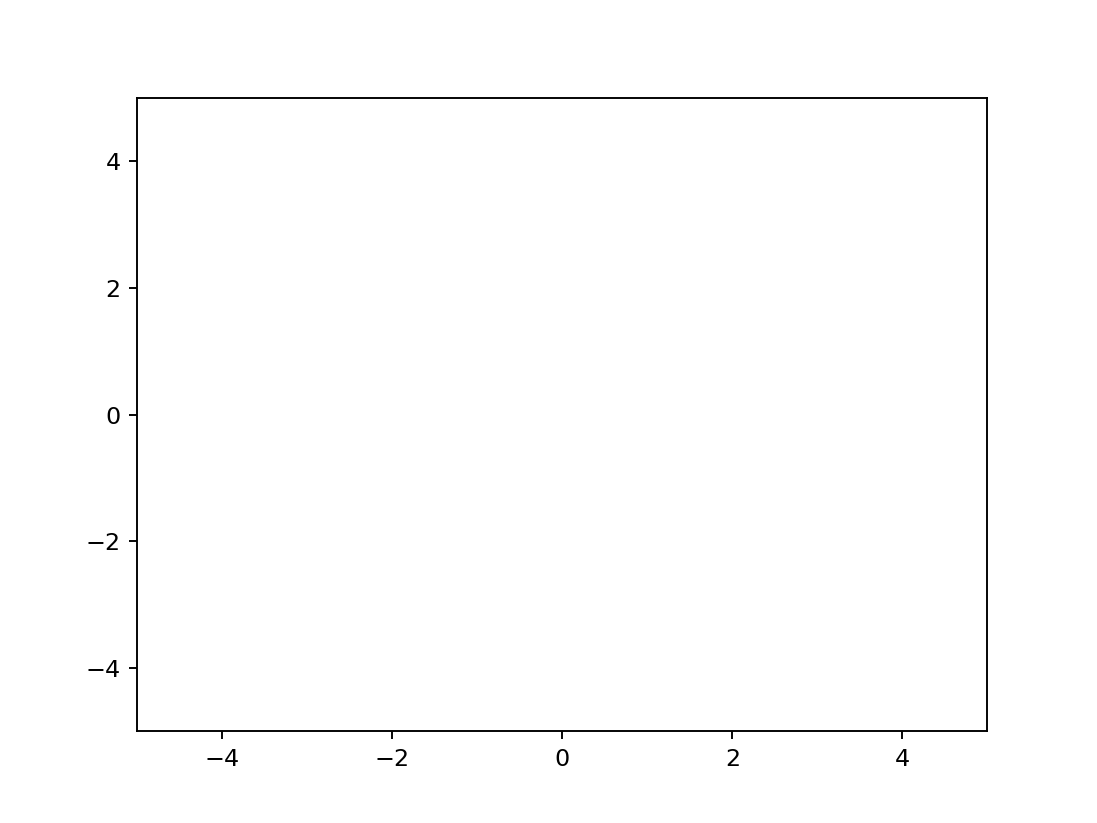

In [18]:
def Nbody_derivatives2(pos,vel) :
    dpdt = vel
    dvdt = np.zeros(vel.shape)
    for i in range(N_bodies) : 
        r = np.linalg.norm( pos-pos[i],axis=-1)
        mass = M[r>0]
        rhat =(pos - pos[i])[r>0]
        r = r[r>0]
        rhat = rhat/r[:,np.newaxis]
        dvdt[i] = ((mass/(r*r))[:,np.newaxis]*rhat).sum(axis=0)
        
    return dpdt, dvdt

%prun positions = run_Nbody_rk2(frames*tframe, tframe, dt, derivatives=Nbody_derivatives2)


fig, ax = plt.subplots(1,1)
ani = FuncAnimation(fig, lambda i : animate(i, positions), frames=len(positions), interval=25, repeat=False)


This was a significant speedup -- about a factor of 20.   This is really excellent.

## Hot spot optimization with numba

Recently python compilation has started to become a thing.  One noteworthy example is numba, which is a jit compiler that works well with numpy. Lets try this one, but using the code originally.  See if you code is faster.

<IPython.core.display.Javascript object>


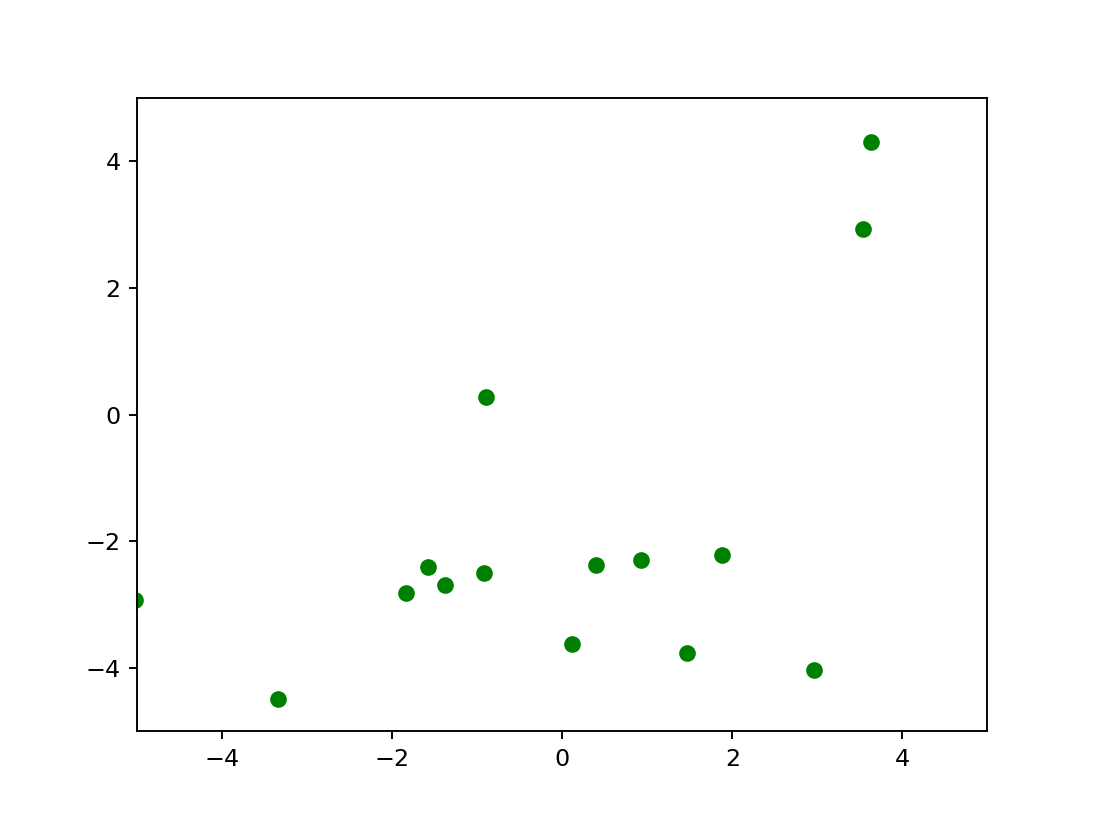

In [19]:
from numba import jit,njit
@jit
def Nbody_derivatives3(pos,vel) :
    dpdt = vel
    dvdt = np.zeros(vel.shape)
    for i in range(N_bodies) :
        for j in range(N_bodies) :
            if i == j : 
                continue
            r = np.linalg.norm( pos[j]-pos[i])
            mass = M[j]
            rhat =(pos[j] - pos[i])/r
            dvdt[i] += mass/(r*r)*rhat
        
    return dpdt, dvdt

%prun positions = run_Nbody_rk2(frames*tframe, tframe, dt, derivatives=Nbody_derivatives3)
fig, ax = plt.subplots(1,1)
ani = FuncAnimation(fig, lambda i : animate(i, positions), frames=frames, interval=25, repeat=False)


This is faster -- nearly a factor of 2 faster than what you with idiomic python and 40x faster than the original version.  Not bad for a simple @jit

## Hot spot optimization with f2py

The final example is using fortran to optimize the slowest bits.  Why fortran?  Because fortran 90 plays extremely well with python.

First we generate the .f90 file.

In [12]:
%%file nbody_derivatives.f90
SUBROUTINE derivs(pos,vel,mass,dpdt,dvdt,n)
    implicit none
    integer, intent(IN) :: n
    double precision, intent(IN), dimension(n,3):: pos, vel
    double precision, intent(IN), dimension(n) :: mass
    double precision, intent(OUT), dimension(n,3):: dpdt, dvdt
!f2py intent(in) n
!f2py intent(in) pos, vel, mass
!f2py intent(out) dpdt, dvdt
!f2py depend(n) mass
    integer :: i, j
    double precision, dimension(3) :: rhat
    double precision :: r,r2
    
    dpdt = vel
    dvdt(:,:) = 0.
    do i = 1,n
        do j = 1,n
            if( i .ne. j) then 
                r2 = sum(pos(j,:)*pos(j,:)+pos(i,:)*pos(i,:))
                r = sqrt(r2)
                rhat(:) =(pos(j,:) - pos(i,:))/r
                dvdt(i,:) = dvdt(i,:)+ mass(j)/(r2)*rhat(:)
            endif
        enddo
    enddo
    
    return
end subroutine

Overwriting nbody_derivatives.f90


In [13]:
!f2py -m nbody_derivatives -c nbody_derivatives.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "nbody_derivatives" sources
f2py options: []
f2py:> /tmp/tmpy4dp06ms/src.linux-x86_64-3.9/nbody_derivativesmodule.c
creating /tmp/tmpy4dp06ms/src.linux-x86_64-3.9
Reading fortran codes...
	Reading file 'nbody_derivatives.f90' (format:free)
Post-processing...
	Block: nbody_derivatives
			Block: derivs
Post-processing (stage 2)...
Building modules...
	Building module "nbody_derivatives"...
		Constructing wrapper function "derivs"...
		  dpdt,dvdt = derivs(pos,vel,mass,[n])
	Wrote C/API module "nbody_derivatives" to file "/tmp/tmpy4dp06ms/src.linux-x86_64-3.9/nbody_derivativesmodule.c"
  adding '/tmp/tmpy4dp06ms/src.linux-x86_64-3.9/fortranobject.c' to sources.
  adding '/tmp/tmpy4dp06ms/src.linux-x86_64-3.9' to include_dirs.
c

<IPython.core.display.Javascript object>


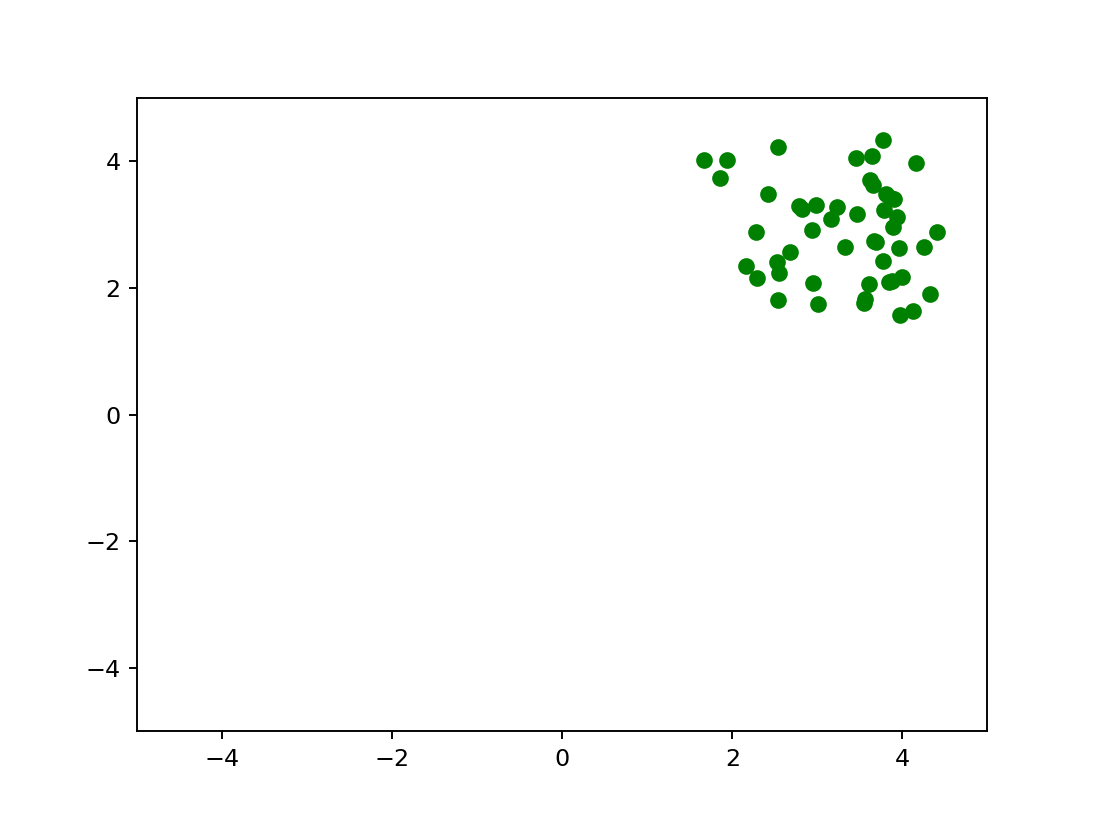

In [20]:
def fortran_derivs(pos,vel) :
    import nbody_derivatives as nbd
    return nbd.derivs(pos,vel,M)
%prun positions = run_Nbody_rk2(frames*tframe, tframe, dt, derivatives=fortran_derivs)
#print(positions)
fig, ax = plt.subplots(1,1)
ani = FuncAnimation(fig, lambda i : animate(i, positions), frames=frames, interval=25, repeat=False)


This is extremely fast like 600x faster than the original code.  Compile code in a highly optimized language is extremely powerful.  